## Imports:

In [1]:
# python
import numpy as np
import pandas as pd
import astropy as ap
import copy
import corner
import math
import statistics

# lenstronomy
from lenstronomy.Util import util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.lens_plot import lens_model_plot
import lenstronomy.Plots.plot_util as plot_util
import lenstronomy.Util.kernel_util as kernel_util
from lenstronomy.Util import util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from memory_profiler import memory_usage

# matplotlib & other plotting
from matplotlib import pyplot as plt
from matplotlib.widgets import RectangleSelector
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import scipy.ndimage as ndimage
plt.style.use(astropy_mpl_style)


## Modeling Functions:

In [2]:
def get_data(filename):
    """
    Input: FITS filename
    Output: data table and image array
    """
    hdu_list = fits.open(filename)  # open
    data = pd.DataFrame(hdu_list[2].data)  # get dataframe data
    image = hdu_list['IMAGE'].data  # get image data
    hdu_list.close()  # close
    return data, image

In [3]:
def plot_image(image_array):
    """
    Input: image array
    Output: plot of image with no grid
    """
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_xticks([])
    ax.grid(False)
    plt.show()
    plt.ioff()

In [4]:
def approx_theta_E(center_x, center_y, x_images, y_images):
    """
    Input: Lens position (center_x, center_y) and image positions
    Output: estimated theta_E
    ** units must be in arcsec **
    """
    d = []

    for i in range(0, len(x_images)):
        x = float(x_images[i])
        y = float(y_images[i])
        x = center_x - x
        y = center_y - y
        dist = math.sqrt(x ** 2 + y ** 2)
        d.append(dist)

    theta_E = statistics.mean(d)
    print(f"'Estimated theta_E': {round(theta_E, 2)}")
    return theta_E

In [16]:
def model_plot_all_bands_withCC(modelPlot, kwargs_result):
    # get image positions from results
    x_images = kwargs_result.get('kwargs_ps')[0].get('ra_image')
    y_images = kwargs_result.get('kwargs_ps')[0].get('dec_image')

    # set kwargs and classes from results
    kwargs_lens_results = kwargs_result.get('kwargs_lens')
    lensModel = LensModel(lens_model_list=['SIE'])

    kwargs_ps_results = [{'ra_image': x_images, 'dec_image': y_images}]
    pointSource = PointSource(point_source_type_list=['LENSED_POSITION'],
                              lensModel=lensModel)

    # find source position from image positions
    x_source_list, y_source_list = lensModel.ray_shooting(x_images,
                                                          y_images,
                                                          kwargs_lens_results)

    # optional: print source positions
    print('The ray traced source positions are: ')
    print(f'ra: {x_source_list}')
    print(f'dec: {y_source_list}')

    # check that model is returning physical quantities
    check_impos = pointSource.check_image_positions(kwargs_ps_results,
                                                    kwargs_lens_results,
                                                    tolerance=0.01)

    check_flux = pointSource.check_positive_flux(kwargs_ps_results)
    print(f'Check Positions: {check_impos}')
    print(f'Check Fluxes: {check_flux}')

    # set up figure
    f, axes = plt.subplots(3, 4, figsize=(20, 15))  # 3 bands x 4 plots

    # set row names: names must be in same order as multi_band_list
    band_names = ['G', 'R', 'I']
    for index, band_name in enumerate(band_names):
        axes[index, 0].set_title(str(band_name)+'-Band')  # set row title

        # plot observed, reconstructed, and normalized residual plots
        modelPlot.data_plot(ax=axes[index, 0],
                            band_index=index)

        modelPlot.model_plot(ax=axes[index, 1],
                             image_names=True,
                             band_index=index)

        modelPlot.normalized_residual_plot(ax=axes[index, 2],
                                           v_min=-6, v_max=6,
                                           band_index=index)

        # settings for critical curves and caustics plot
        kwargs_lens_plot = {'with_caustics': True,
                            'fast_caustic': True,
                            'point_source': True,
                            'with_convergence': True,
                            'numPix': numPix,
                            'deltaPix': deltaPix}

        # plot critical curves and caustics
        lens_model_plot(axes[index, 3], lensModel,
                        kwargs_lens_results,
                        sourcePos_x=statistics.mean(x_source_list),
                        sourcePos_y=statistics.mean(y_source_list),
                        **kwargs_lens_plot)

    plt.show()

In [6]:
# background_rms functions
def get_hist_stats(flat_image):
    """
    Input: 1d numpy array of image (flattened image)
           note: to flatten an image use '1d_array = 2d_array.flatten()'
    Output: number of bins for histogram based on spread of data,
            integer values of min and max (used for range of x-axis)
            root mean square value
    """
    min_int = math.floor(np.amin(flat_image))  # round min down to int
    max_int = math.ceil(np.amax(flat_image))  # round max up to int
    Bins = abs(min_int)+max_int  # num bins = one per integer value
    rms = np.sqrt(np.mean(flat_image**2))  # calculate rms
    return Bins, min_int, max_int, rms


def get_rms_fast(filename, coadd_id, extents):
    """
    Short Version:
    Input: filename, coadd_id of image, and background region
    Output: rms_list [g,r,i]
    """
    # grab correct crop region from extents
    crop = []
    for ext in extents:
        ext = int(ext)  # must be an int for cropping
        if ext > numPix:
            ext = int(ext - 1)  # crop is <= image size
            crop.append(ext)
        elif ext < 0:
            ext = int(ext + 1)  # crop is >= 0
            crop.append(ext)
        else:
            crop.append(ext)

    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0]:crop[1], crop[2]:crop[3]]
    r_crop = image[row, 1, crop[0]:crop[1], crop[2]:crop[3]]
    i_crop = image[row, 2, crop[0]:crop[1], crop[2]:crop[3]]

    # list of flattened images (1d image arrays)
    band_flats = [g_crop.flatten(), r_crop.flatten(), i_crop.flatten()]
    rms_list = []  # rms values will be saved here and returned

    # loop to get rms for each band
    for index, flat_image in enumerate(band_flats):
        _, _, _, rms = get_hist_stats(flat_image)  # get rms
        rms_list.append(rms)  # save rms

    return rms_list

In [7]:
def add_mask(band, kwargs_data, kwargs_psf, mask_2d):
    """
    Input: band (g,r,i) plus corresponding kwargs_data and kwargs_psf,
           kwargs_numerics
    Output: kwargs_data with masked image
    """
    # settings
    data_class = ImageData(**kwargs_data)
    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    imageFit = ImageLinearFit(data_class=data_class,
                              psf_class=psf_class,
                              kwargs_numerics=kwargs_numerics,
                              likelihood_mask=mask_2d)

    # apply mask to image
    mask_1d = imageFit.image2array_masked(band)
    masked_image = imageFit.array_masked2image(mask_1d)

    # update kwargs_data and mask_list_band with masked image
    kwargs_data.update({'image_data': masked_image})

    return kwargs_data, masked_image

In [8]:
# MODEL
def model(coadd_id, extents_dict):
    """
    ===================================================
    INPUT: 
    * coadd_id
    * extents_dict from interactive selector
    ===================================================
    OUTPUT: 
    * RGB image
    * For each band:
        * observed image
        * modeled image
        * normalized residuals,
        * lens model with critical curves and caustics
    * Fitting results from PSO and MCMC
    ===================================================
    """
    # extents = (xmin, xmax, ymin, ymax)
    # image positions:
    image_extents = [extents_dict.get('2'),
                     extents_dict.get('3'),
                     extents_dict.get('4'),
                     extents_dict.get('5')]
    image_extents = list(filter(None, image_extents))  # remove empty selectors

    ra_images = []  # center ra positions
    dec_images = []  # center dec positions
    ra_low = []  # lower ra bounds
    ra_upp = []  # upper ra bounds
    dec_low = []  # lower dec bounds
    dec_upp = []  # upper dec bounds

    for img in image_extents:
        # translate coords to arcsec
        ra_min = (img[0]-(numPix/2))*deltaPix
        ra_max = (img[1]-(numPix/2))*deltaPix
        dec_min = (img[2]-numPix/2)*deltaPix
        dec_max = (img[3]-(numPix/2))*deltaPix

        # centers
        center_ra = statistics.mean([ra_min, ra_max])
        center_dec = statistics.mean([dec_min, dec_max])
        ra_images.append(center_ra)
        dec_images.append(center_dec)

        # bounds
        ra_low.append(ra_min)
        ra_upp.append(ra_max)
        dec_low.append(dec_min)
        dec_upp.append(dec_max)

    # lens position:
    lens_extents = extents_dict['1']

    # translate coords to arcsec
    lens_min_ra = (lens_extents[0]-(numPix/2))*deltaPix
    lens_max_ra = (lens_extents[1]-(numPix/2))*deltaPix
    lens_min_dec = (lens_extents[2]-numPix/2)*deltaPix
    lens_max_dec = (lens_extents[3]-(numPix/2))*deltaPix

    # centers
    lens_ra = statistics.mean([lens_min_ra, lens_max_ra])
    lens_dec = statistics.mean([lens_min_dec, lens_max_dec])

    # background:
    rms_list = get_rms_fast(filename, coadd_id, extents_dict['0'])
    rms_g = rms_list[0]
    rms_r = rms_list[1]
    rms_i = rms_list[2]

    # mask_list
    mask_extents = [extents_dict.get('6'),
                    extents_dict.get('7')]
    mask_extents = list(filter(None, mask_extents))  # remove unused selectors

    mask_list = []
    if len(mask_extents) == 0:
        mask_list = mask_list
    else:
        for mask in mask_extents:
            # translate coords to arcsec
            mask_ra_min = (mask[0]-(numPix/2))*deltaPix
            mask_ra_max = (mask[1]-(numPix/2))*deltaPix
            mask_dec_min = (mask[2]-numPix/2)*deltaPix
            mask_dec_max = (mask[3]-(numPix/2))*deltaPix

            # center
            mask_ra = statistics.mean([mask_ra_min, mask_ra_max])
            mask_dec = statistics.mean([mask_dec_min, mask_dec_max])

            # radius:
            mask_r = statistics.mean([mask_ra_max-mask_ra,
                                      mask_dec_max-mask_dec])

            # add mask to mask list
            mask_list.append({'mask_x': mask_ra,
                              'mask_y': mask_dec,
                              'mask_r': mask_r})

    # Image data
    data, image = get_data(filename)

    # index dataframe by coadd_id
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :]  # get image array
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    fwhm_g = data.iloc[row, 27]  # get fwhm
    fwhm_r = data.iloc[row, 28]
    fwhm_i = data.iloc[row, 29]

    # set models to use
    # input for point source is image positions, not source position
    lens_model_list = ['SIE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    point_source_list = ['LENSED_POSITION']

    # generate coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix, deltaPix, subgrid_res=1, center_ra=0, center_dec=0, inverse=False)

    # generate image data for each band
    kwargs_data_g = {'background_rms': rms_g,  # from background section
                     'exposure_time': exp_time,  # from DES camera
                     'ra_at_xy_0': ra_at_xy_0,  # ra at (0,0)
                     'dec_at_xy_0': dec_at_xy_0,  # dec at (0,0)
                     'transform_pix2angle': Mpix2coord,  # coords in arcsec
                     'image_data': g}  # 2d image array

    kwargs_data_r = {'background_rms': rms_r,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': r}

    kwargs_data_i = {'background_rms': rms_i,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': i}

    # set kwargs_psf depending on psf_type
    kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g,
                    'pixel_size': deltaPix, 'truncation': 4}
    kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r,
                    'pixel_size': deltaPix, 'truncation': 4}
    kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i,
                    'pixel_size': deltaPix, 'truncation': 4}

    # add mask(s)
    if len(mask_list) != 0:
        # get 2d grid for ra, dec
        ra_grid_2d = util.array2image(ra_grid)
        dec_grid_2d = util.array2image(dec_grid)

        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_x'),
                                               center_y=mask.get('mask_y'),
                                               r=mask.get('mask_r'),
                                               x_grid=ra_grid_2d,
                                               y_grid=dec_grid_2d)

            # add mask to data in each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g,
                                        kwargs_psf_g, mask_2d)

            kwargs_data_r, r = add_mask(r, kwargs_data_r,
                                        kwargs_psf_r, mask_2d)

            kwargs_data_i, i = add_mask(i, kwargs_data_i,
                                        kwargs_psf_i, mask_2d)

        # add masked arrays to likelihood
        image_likelihood_mask_list = [g, r, i]

        # plot each band with mask(s) for reference
        plot_image(g)
        plot_image(r)
        plot_image(i)

    elif len(mask_list) == 0:
        pass
    else:
        print('Please add mask or set mask_list = []')

    # Settings for model
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    # combine models
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # not modeling fluxes

    num_images = len(ra_images)  # number of images
    kwargs_constraints = {'num_point_source_list': [num_images],
                          # vary centers of lens mass and light together:
                          'joint_lens_with_light': [[0, 0,
                                                     ['center_x', 'center_y']]]
                          }

    kwargs_likelihood = {'check_bounds': True,  # punish models outside bounds
                         'force_no_add_image': False,  # allow imgs to be added
                         'image_position_uncertainty': 0.01,  # img pos. uncertainty
                         'check_matched_source_position': True,  # punish models without same ray-traced source pos.s
                         'check_positive_flux': True,  # punish models with non-physical fluxes
                         'source_position_tolerance': 0.01,  # for ray-traced source pos.s
                         'source_position_sigma': 0.01,  # source pos. uncertainty
                         'image_likelihood': True,  # liklihood for images
                         'image_likelihood_mask_list': image_likelihood_mask_list
                         }

    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list,
                         'multi_band_type': 'multi-linear'}

    # Add parameters to model:
    theta_E = approx_theta_E(lens_ra, lens_dec, ra_images, dec_images)

    # lens
    kwargs_lens_fixed = [{}]  # fixed parameters
    kwargs_lens_init = [{'theta_E': theta_E, 'e1': 0., 'e2': 0.,
                         'center_x': lens_ra, 'center_y': lens_dec}]  # initial
    kwargs_lens_sigma = [{'theta_E': 0.1, 'e1': 0.05, 'e2': 0.05,
                          'center_x': 0.01, 'center_y': 0.01}]  # step sizes
    kwargs_lower_lens = [{'theta_E': theta_E - 0.7, 'e1': -0.5, 'e2': -0.5,
                          'center_x': lens_min_ra,
                          'center_y': lens_min_dec}]  # lower bounds
    kwargs_upper_lens = [{'theta_E': theta_E + 0.7, 'e1': 0.5, 'e2': 0.5,
                          'center_x': lens_max_ra,
                          'center_y': lens_max_dec}]  # upper bounds

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [{'R_sersic': 1., 'n_sersic': 2.,
                               'e1': 0., 'e2': 0.,
                               'center_x': lens_ra, 'center_y': lens_dec}]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1,
                                'e1': 0.05, 'e2': 0.05,
                                'center_x': 0.01, 'center_y': 0.01}]
    kwargs_lower_lens_light = [{'R_sersic': 0.01, 'n_sersic': 0.01,
                                'e1': -0.5, 'e2': -0.5,
                                'center_x': lens_min_ra,
                                'center_y': lens_min_dec}]
    kwargs_upper_lens_light = [{'R_sersic': 11, 'n_sersic': 10.,
                                'e1': 0.5, 'e2': 0.5,
                                'center_x': lens_max_ra,
                                'center_y': lens_max_dec}]

    # point source image positions
    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': ra_images, 'dec_image': dec_images}]
    kwargs_ps_sigma = [{'ra_image': [0.01]*num_images,
                        'dec_image': [0.01]*num_images}]
    kwargs_lower_ps = [{'ra_image': ra_low, 'dec_image': dec_low}]
    kwargs_upper_ps = [{'ra_image': ra_upp, 'dec_image': dec_upp}]

    # combine params
    lens_params = [kwargs_lens_init,
                   kwargs_lens_sigma,
                   kwargs_lens_fixed,
                   kwargs_lower_lens,
                   kwargs_upper_lens]

    lens_light_params = [kwargs_lens_light_init,
                         kwargs_lens_light_sigma,
                         kwargs_lens_light_fixed,
                         kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    ps_params = [kwargs_ps_init,
                 kwargs_ps_sigma,
                 fixed_ps,
                 kwargs_lower_ps,
                 kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                     'lens_light_model': lens_light_params,
                     'point_source_model': ps_params}

    # Fitting
    # Combine everything from above for the fitting process
    fitting_seq = FittingSequence(kwargs_data_joint,
                                  kwargs_model,
                                  kwargs_constraints,
                                  kwargs_likelihood,
                                  kwargs_params)

    # General Settings
    particles = 400
    iterations = 400
    burn = 200
    run = 600

    # PSO Settings
    PSO_list = ['PSO', {'sigma_scale': 1.,
                        'n_particles': particles,
                        'n_iterations': iterations}]

    # MCMC Settings
    MCMC_list = ['MCMC', {'n_burn': burn, 'n_run': run,
                          'walkerRatio': 10, 'sigma_scale': .1}]

    fitting_kwargs_list = [PSO_list, MCMC_list]  # run a PSO, then the MCMC

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    # Show final results
    # update model plot class
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                          image_likelihood_mask_list,
                          arrow_size=0.02, cmap_string="gist_heat")

    # plot RGB image
    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    plot_image(rgb_image)

    # plot all observed, reconstructed, residuals, & lens models
    model_plot_all_bands_withCC(modelPlot, kwargs_result)

    # Results of MCMC chain
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[1]
    for i in range(len(chain_list)):
        chain_plot.plot_chain_list(chain_list, i)

    print(f"number of free parameters in the MCMC: {len(param_mcmc)}")
    print(f"parameters in order: {param_mcmc}")
    n_sample = len(samples_mcmc)
    print(f"number of samples: {n_sample}")
    samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]

    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:, :],
                         labels=param_mcmc[:],
                         show_titles=True)


## Grab Data from FITS

In [9]:
# set filename(s)
filepath = '/Users/gilliancartwright/Desktop/summerproject/Data/'
filename = filepath + 'Quasars.fits'

# show data table for reference
data, image = get_data(filename)

numPix = 46
deltaPix = 0.2637
exp_time = 90.
coadd_id = 1532350418
data.head(2)

,NAME,COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,...,IMAFLAGS_ISO_I,IMAFLAGS_ISO_Z,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,FWHM_WMEAN_Z,SKYBRITE_WMEAN_G,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z
0,DESJ0112-1650,1146879846,DES0112-1707,1098276694,68642293,0.291241,18.141220,-16.840985,3.932359,3.878177,...,0,0,1.05814,0.920101,0.841518,0.787317,414.192993,1118.079956,3729.070068,7356.490234
1,DESJ0501-4118,1532350418,DES0503-4123,2241453493,140090843,0.101100,75.441381,-41.300335,3.099320,3.545753,...,0,0,1.08129,1.027810,0.867825,0.901882,320.069000,927.046997,2752.050049,4901.779785


## Interactive Functions

The interactive section of this notebook allows you to select regions to use for the modeling later. Here are all the regions the model needs to work: 
* __Background:__ a region of the data where no objects are present. _Why?_ to calculate background_rms: an estimate of background noise
* __Lens__: a region of the data where the lens is. _Why?_ the center of the region gives an initial parameter for the lens position, and the edges of the region give upper and lower bounds for the lens position
* __Images:__ up to 4 regions where images are present. _Why?_ the center of each region gives an initial parameter for the respective image positions, and the edges of each region give upper and lower bounds for the respective image positions
* __Masks__: up to 2 regions of excessive noise (ex. due to another object) that should be discluded from the modeling.

Finding all these regions by hand can take a long time. With this interactive plot, you can easily select the regions you need and toggle between selectors. The required parameters can be saved and plugged into the lens model.

In [10]:
# run interactive magic
%matplotlib ipympl

In [11]:
def pick_selector(event):
    """
    Press number key 1, 2, 3, 4, or 5 to turn the corresponding selector on
    """
    if event.key == 'b':  # dictionary key = '0'
        activate_selector(selector_dict['0'])
        text.set_text("Background selector is ON")

    if event.key == '0':  # dictionary key = '1'
        activate_selector(selector_dict['1'])
        text.set_text("Lens selector is ON")

    if event.key == '1':  # dictionary key = '2'
        activate_selector(selector_dict['2'])
        text.set_text("Image selecter 1 is ON")

    if event.key == '2':  # dictionary key = '3'
        activate_selector(selector_dict['3'])
        text.set_text("Image selector 2 is ON")

    if event.key == '3':  # dictionary key = '4'
        activate_selector(selector_dict['4'])
        text.set_text("Image selector 3 is ON")

    if event.key == '4':  # dictionary key = '5'
        activate_selector(selector_dict['5'])
        text.set_text("Image selector 4 is ON")

    if event.key == 'm':  # dictionary key = '6'
        activate_selector(selector_dict['6'])
        text.set_text("Mask 1 selector is ON")

    if event.key == 'M':  # dictionary key = '7'
        activate_selector(selector_dict['7'])
        text.set_text("Mask selector 2 is ON")

    else:
        pass


def activate_selector(selector):
    """
    Given a desired selector, activates *only* that selector
    """
    for key in selector_dict:
        selector_dict[key].set_active(False)  # turn off all selectors
    selector.set_active(True)  # turn on desired selector


def on_select(eclick, erelease):
    """
    Click and drag to span rectangle selector
    """
    return


def save_selection(event):
    """
    press 't' and the current selector's extents are saved
    in dictionary with corresponding key
    """
    if event.key == 't':
        # set extents_dict to global to save it after the function
        global exents_dict

        # pick the active selector
        for key in selector_dict:
            if selector_dict[key].active == True:
                selector = selector_dict[key]  # set selector
                selector_num = key  # set key for extents_dict

            else:
                # fail safe if all selectors are off
                text.set_text('Cannot save selection because all selectors are OFF.')

        extents_dict.update({selector_num: selector.extents})  # save extents corresponding to key
        selector.set_active(False)  # turn off selector
        text.set_text('Your selection has been saved. All selectors are OFF')  # update text

    else:
        pass


def on_close(event):
    """
    Press 'q' to close image
    '"""
    if event.key == 'q':
        text.set_text('CLOSED')
        plt.close()



## Run interactive image
Follow the instructions to select and save regions for your model. You must select a background, lens, and at least one image. You may select up to 4 images and up to 2 masks.

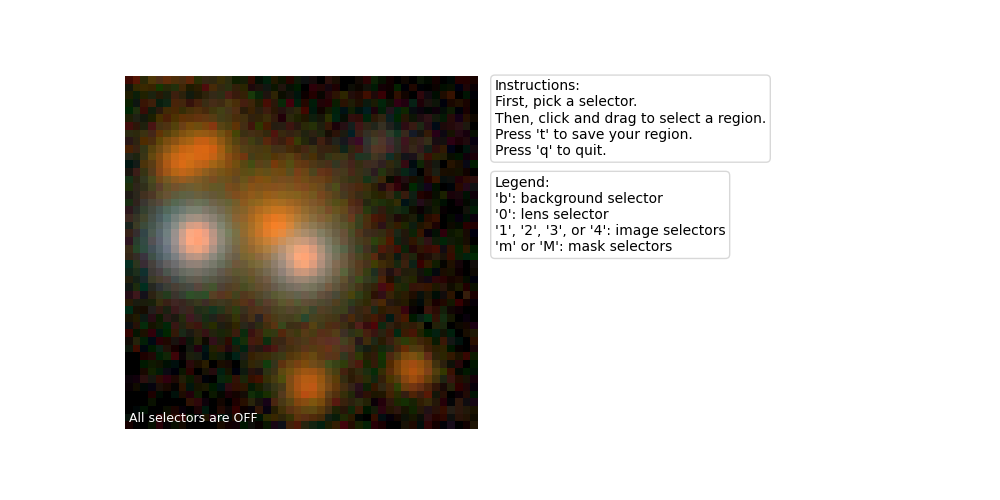

In [13]:
# Data
data, image = get_data(filename)
row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]  # index by coadd_id

g = image[row, 0, :, :]  # get image arrays
r = image[row, 1, :, :]
i = image[row, 2, :, :]

# combine into RGB image
rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)

# Plotting
# ax[0] used for image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # create figure
ax[0].imshow(rgb_image, origin='lower')  # show image
ax[0].axis('off')  # turn off grids and ticks
text = ax[0].text(0, 0, "",
                  va="bottom", ha="left",
                  fontsize=9, color='white')  # create empty text

# ax[1] used for legend and instructions
# instructions text
legend_txt = ("Instructions:\n"
              + "First, pick a selector.\n"
              + "Then, click and drag to select a region.\n"
              + "Press 't' to save your region.\n"
              + "Press 'q' to quit.")

# instruction text settings
ax[1].text(-0.15, 0.95, legend_txt, fontsize=10,
           va='top', ha='left', bbox={'boxstyle': 'round',
                                      'facecolor': 'white',
                                      'alpha': 0.75})

# legend text
legend_txt = ("Legend:\n"
              + "'b': background selector\n"
              + "'0': lens selector\n"
              + "'1', '2', '3', or '4': image selectors\n"
              + "'m' or 'M': mask selectors")

# legend settings
ax[1].text(-0.15, 0.7, legend_txt, fontsize=10,
           va='top', ha='left', bbox={'boxstyle': 'round',
                                      'facecolor': 'white',
                                      'alpha': 0.75})

ax[1].axis('off')  # turn off grid and ticks

# Create selectors
color_list = ['orange',  # background
              'yellow',  # lens
              'cyan', 'cyan', 'cyan', 'cyan',  # images
              'red', 'red']  # masks

# create dictionary of selectors
selector_dict = {}
for i in range(len(color_list)):
    props = {'facecolor': color_list[i],  # fill color
             'edgecolor': 'black',  # edge color
             'alpha': 0.2,  # opacity
             'fill': True}  # filled

    selector_dict.update({str(i):
                          RectangleSelector(ax[0],  # ax
                                            on_select,  # click & release
                                            useblit=True,  # backend type
                                            button=[1, 3],  # no middle button
                                            minspanx=5,
                                            minspany=5,  # min span = 5 pix
                                            spancoords='pixels',  # using pixls
                                            props=props,  # color settings
                                            interactive=True)  # adjustable
                          })

# start with all selectors off
for key in selector_dict:
    selector_dict[key].set_active(False)
text.set_text('All selectors are OFF')

# create empty dictionary to save extents later:
extents_dict = {}

# Event functions:
# run pick selector function
cid = fig.canvas.mpl_connect('key_press_event', pick_selector)

# run save function
cid = fig.canvas.mpl_connect('key_press_event', save_selection)

# run close function
cid = fig.canvas.mpl_connect('key_press_event', on_close)

# Display
plt.show()

In [14]:
# switch to inline backend
%matplotlib inline

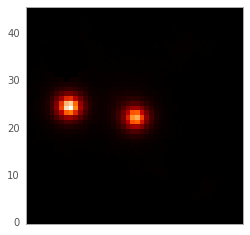

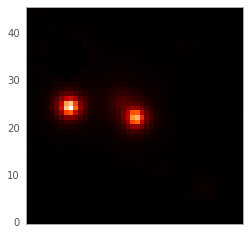

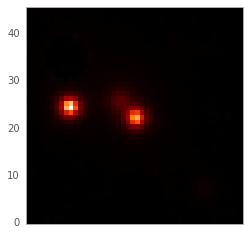

'Estimated theta_E': 2.16
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Converged after 152 iterations!
Best fit found:  -33510.823088567304 [2.1410106167946283, -0.1638267892774657, -0.2997792273990576, 4.8713047324432, 3.6291820779858845, 0.16337048369970827, -0.08791346425988601, -0.761920233939613, 0.655332250903895, -3.647856402876243, 0.050214132478579206, 0.47460504432225775, -0.16337143065800644]
-11.571416812350588 reduced X^2 of best position
-33510.823088567304 logL
5792.0 effective number of data points
[{'theta_E': 2.1410106167946283, 'e1': -0.1638267892774657, 'e2': -0.2997792273990576, 'center_x': -0.761920233939613, 'center_y': 0.655332250903895}] lens result
[] source result
[{'amp': 1, 'R_sersic': 4.8713047324432, 'n_sersic': 3.6291820779858845, 'e1': 0.16337048369970827, 'e2': -0.08791346425988601, 'center_x': -0.761920233939613, 'center_y': 0.655332250903895}] lens light result
[{'ra_image': array([-3.6478564 ,  0.05021413]), 'dec_image': 

100%|██████████| 800/800 [06:26<00:00,  2.07it/s]

Computing the MCMC...
Number of walkers =  130
Burn-in iterations:  200
Sampling iterations (in current run): 800
387.29393792152405 time taken for MCMC sampling
-11.527793932329159 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  16.48674525621714
reduced chi^2 of data  1 =  8.768564910011039
reduced chi^2 of data  2 =  9.328071630759297


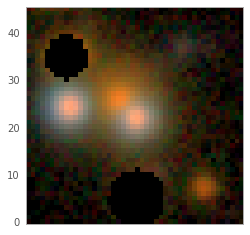

The ray traced source positions are: 
ra: [-1.42437292 -1.42122921]
dec: [1.02820422 1.02817629]
Check Positions: True
Check Fluxes: True


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning

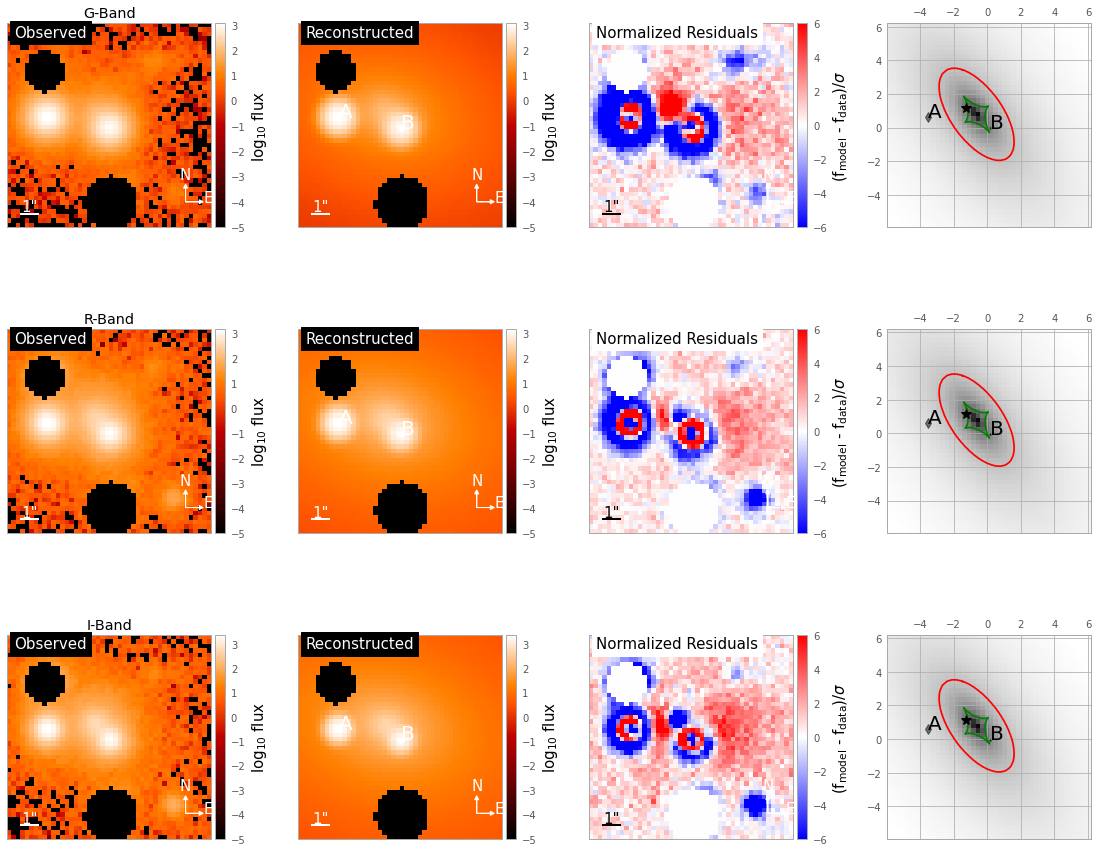

number of free parameters in the MCMC: 13
parameters in order: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'dec_image', 'dec_image']
number of samples: 78000


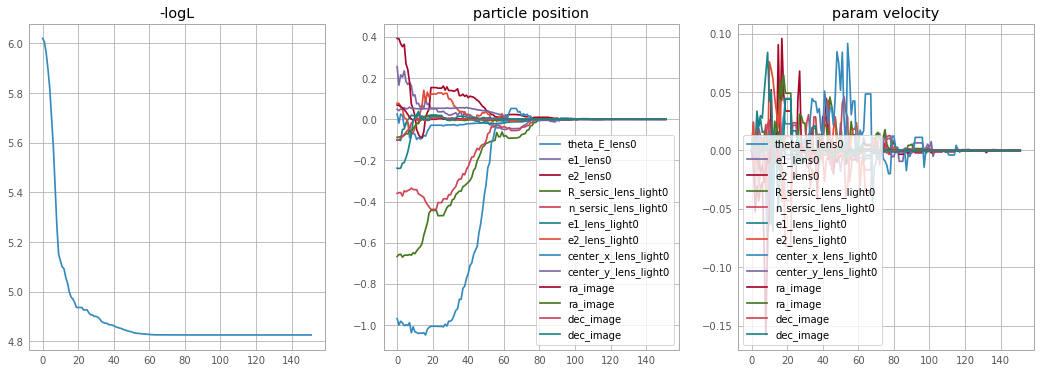

<Figure size 432x288 with 0 Axes>

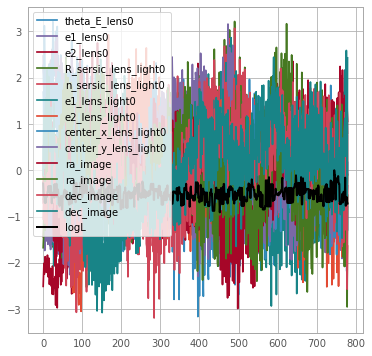

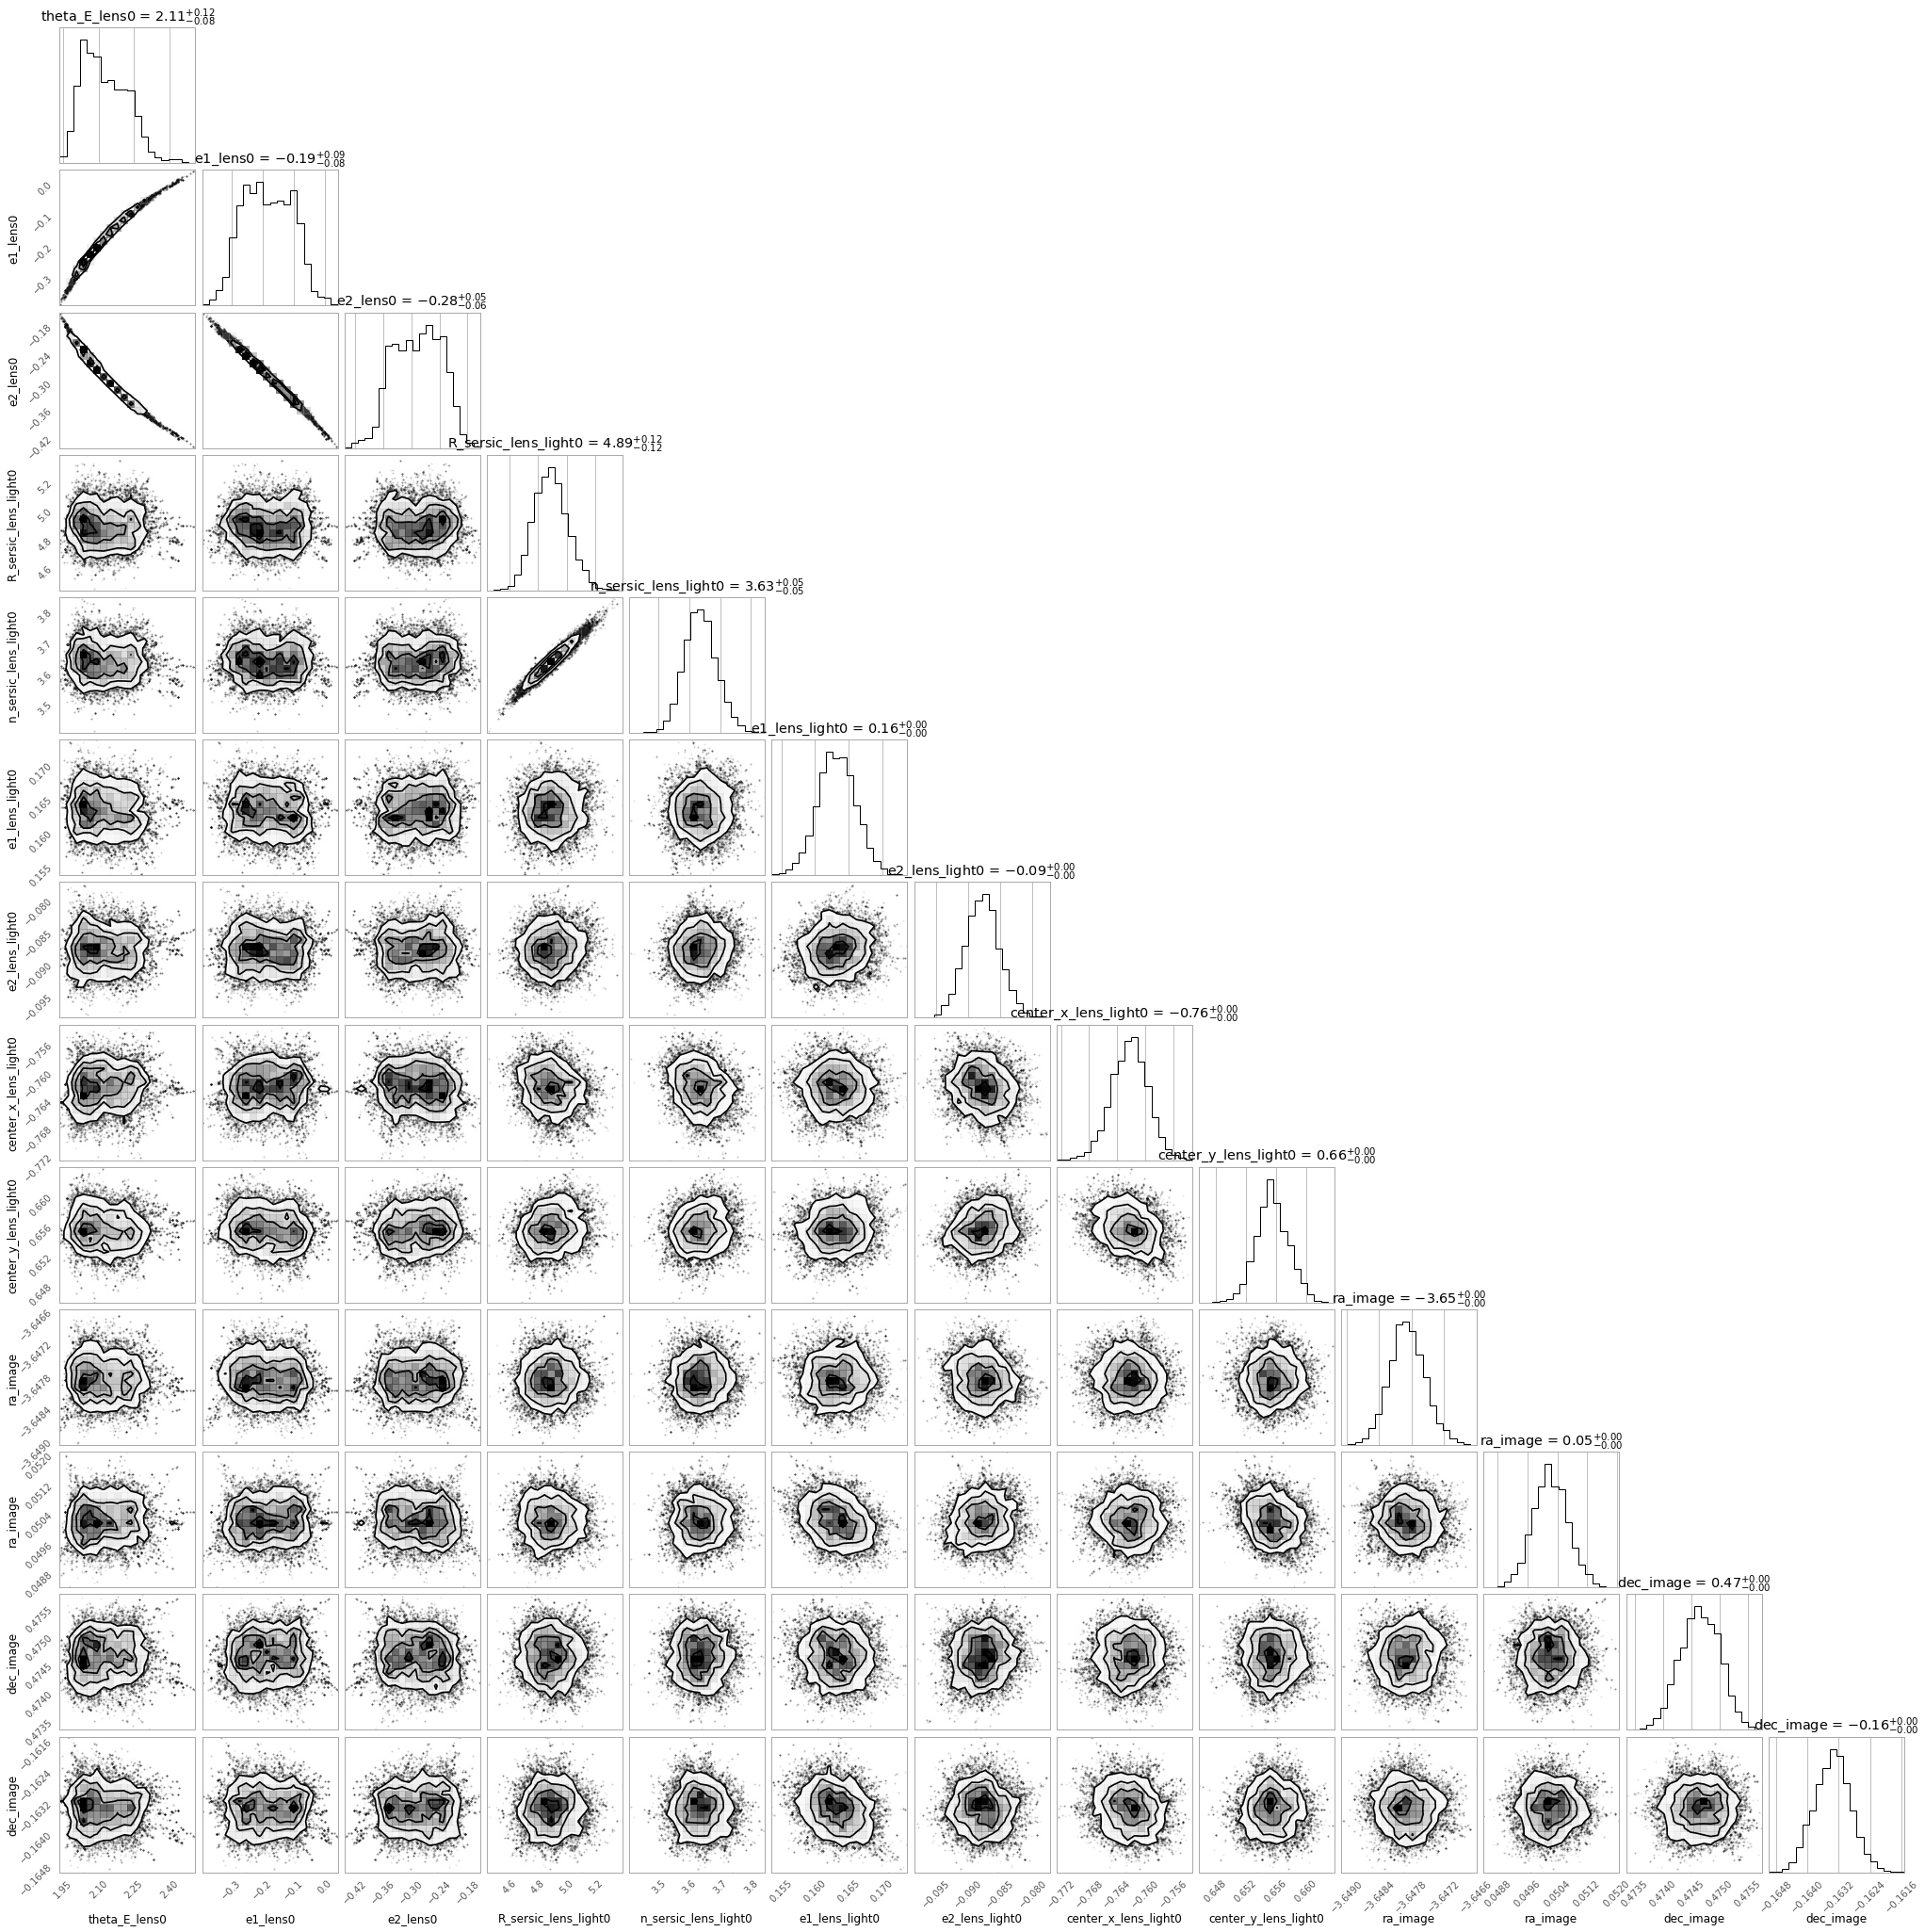

In [17]:
model(coadd_id, extents_dict)

In [18]:
plt.close('all')